In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import os
import subprocess

import random as random
import scipy.stats as stats

## Analyze PCA data for E64V and R73G
Many DHFR[3] variants had to be dropped due to mutations in the Fcy1 or linker sequences, which came in after the growth curves were ran

In [19]:
row_96_to_row_384 = {'A':['B', 'C'], 
                     'B':['D', 'E'],
                     'C':['F', 'G'],
                     'D':['H', 'I'],
                     'E':['J', 'K'],
                     'F':['L', 'M'],
                     'G':['N', 'O']}

col_96_to_col_384 = {'1':['2','3'],
                     '2':['4','5'],
                     '3':['6','7'],
                     '4':['8','9'],
                     '5':['10','11'],
                     '6':['12','13'],
                     '7':['14','15'],
                     '8':['16','17'],
                     '9':['18','19'],
                     '10':['20','21'],
                     '11':['22','23']}

def get_384_wells_from_96(well):
    row = well[0]
    col = well[1:]
    
    well_list = []
    
    for y in row_96_to_row_384[row]:
        for x in col_96_to_col_384[col]:
            coord = y+x
            
            well_list.append(coord)
            
    return well_list

get_384_wells_from_96('A1')

['B2', 'B3', 'C2', 'C3']

In [20]:
def get_derivative_growth_rate(well, df, tmax=25):
    # well : a tuple of the format (row, col)
    # source : DataFrame where well was measured
    # tmax : defines the interval in which the function will measure the growth rate, from t=0 to t=tmax
    
    df_cols = [ x for x in list(df.index) if x<=tmax]
    # define time range
    
    df_data = df.loc[df_cols]
    # select the subset of the DataFrame in the selected timerange
    data = df_data[(well[0]+str(well[1]))]
    # 

    data_diff = data.diff()*4
    
    get_top_5 = data_diff.nlargest(5)
    
    growth_rate = np.median(get_top_5)
    std_err = np.std(get_top_5)
    
    return growth_rate, std_err

In [21]:
def format_table(imported_df):
    
    rename_dict = {}


    for col_name in imported_df.columns:
        to_hours = np.float64(col_name.strip('s'))/(60*60)
        rename_dict[col_name] = to_hours
    
    imported_df.rename(columns = rename_dict, inplace=True)

In [22]:
pca_array = pd.read_excel('./misc_data/array_diploid_PCA_96_well.xlsx', index_col=0)
pca_array

,source_plate,source_row,source_col,dest_row,dest_col,mata,matalpha
index,,,,,,,
0,Mata1_MATal1,C,1,A,1,WT_1,H62C_1
1,Mata1_MATal1,D,1,B,1,WT_1,E64V_3x_1
2,Mata1_MATal2,D,1,C,1,WT_1,R73G_2
3,Mata1_MATal1,E,1,D,1,WT_1,R73_3x_1
4,Mata1_MATal1,F,1,E,1,WT_1,L74P_1
...,...,...,...,...,...,...,...
65,Mata2_MATal2,D,1,C,11,WT_2,R73G_2
66,Mata2_MATal1,E,1,D,11,WT_2,R73_3x_1
67,Mata2_MATal1,F,1,E,11,WT_2,L74P_1


In [23]:
pca_array['DMSO_1_well'] = 'none'
pca_array['DMSO_2_well'] = 'none'
pca_array['MTX_1_well'] = 'none'
pca_array['MTX_2_well'] = 'none'

for row in list(pca_array.index):
    
    well = pca_array.loc[row]['dest_row']+str(pca_array.loc[row]['dest_col'])
    get_384_wells_from_96(well)

    pca_array.at[row, 'DMSO_1_well'], pca_array.at[row, 'DMSO_2_well'], pca_array.at[row, 'MTX_1_well'], pca_array.at[row, 'MTX_2_well'] = get_384_wells_from_96(well)
    
strain_subset = pca_array[(pca_array['matalpha'].isin(['E64V_3x_1', 'R73G_2']))&(pca_array['mata']!='R53D_1')]


In [24]:
pca_data = pd.read_excel('./misc_data/384_DHFR_PCA.xlsx', skiprows=[0,2]+[x for x in range(387,419)], index_col=0)
format_table(pca_data)
pca_data

,0.000000,0.250000,0.500000,0.750000,0.999722,1.249722,1.499722,1.749722,1.999722,2.249722,...,69.495833,69.745833,69.995833,70.245833,70.495833,70.745833,70.995833,71.245556,71.495556,71.745556
A1,0.092777,0.092580,0.092675,0.092633,0.092532,0.092451,0.092504,0.092382,0.092429,0.092439,...,0.092335,0.092315,0.092377,0.092270,0.092320,0.092309,0.092291,0.092346,0.092441,0.092393
A2,0.093736,0.093525,0.093567,0.093525,0.093412,0.093293,0.093401,0.093224,0.093323,0.093300,...,0.093346,0.093365,0.093386,0.093276,0.093332,0.093376,0.093414,0.093368,0.093534,0.093451
A3,0.094562,0.094526,0.094564,0.094514,0.094382,0.094241,0.094362,0.094116,0.094238,0.094213,...,0.094376,0.094357,0.094339,0.094305,0.094407,0.094410,0.094409,0.094362,0.094520,0.094423
A4,0.093135,0.093020,0.093076,0.092938,0.092771,0.092657,0.092790,0.092567,0.092647,0.092628,...,0.092774,0.092794,0.092783,0.092796,0.092874,0.092824,0.092853,0.092806,0.093007,0.092857
A5,0.091935,0.091855,0.091865,0.091761,0.091577,0.091465,0.091561,0.091344,0.091398,0.091438,...,0.091573,0.091563,0.091597,0.091559,0.091570,0.091578,0.091579,0.091500,0.091703,0.091629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P20,0.093875,0.094114,0.093918,0.093438,0.093503,0.093715,0.093578,0.093130,0.093378,0.093377,...,0.095161,0.095244,0.095131,0.095053,0.095150,0.094954,0.094992,0.094869,0.095038,0.095009
P21,0.095277,0.095425,0.095432,0.094619,0.094523,0.094555,0.094400,0.094038,0.094339,0.094204,...,0.094325,0.094303,0.094237,0.094272,0.094516,0.094240,0.094352,0.094296,0.094503,0.094396
P22,0.093804,0.093909,0.093674,0.092977,0.092891,0.092958,0.092797,0.092681,0.092839,0.092548,...,0.093531,0.093555,0.093410,0.093473,0.093591,0.093571,0.093543,0.093422,0.093506,0.093536
P23,0.096310,0.096264,0.096408,0.096167,0.096056,0.096078,0.096097,0.096006,0.096102,0.095995,...,0.096214,0.096108,0.096071,0.096237,0.096356,0.096277,0.096191,0.096072,0.096230,0.096145


In [25]:
## will use t=40 for max growth rate

In [26]:
pca_array['DMSO_1'] = np.NaN
pca_array['DMSO_2'] = np.NaN
pca_array['MTX_1'] = np.NaN
pca_array['MTX_2'] = np.NaN

In [27]:
for row in list(pca_array.index):
    
    dmso_1_well = pca_array.loc[row]['DMSO_1_well']
    pca_array.at[row, 'DMSO_1'] = get_derivative_growth_rate(tuple([dmso_1_well[0], int(dmso_1_well[1:])]), pca_data.T, tmax=40)[0]
    
    dmso_2_well = pca_array.loc[row]['DMSO_2_well']
    pca_array.at[row, 'DMSO_2'] = get_derivative_growth_rate(tuple([dmso_2_well[0], int(dmso_2_well[1:])]), pca_data.T, tmax=40)[0]
    
    
    mtx_1_well = pca_array.loc[row]['MTX_1_well']
    pca_array.at[row, 'MTX_1'] = get_derivative_growth_rate(tuple([mtx_1_well[0], int(mtx_1_well[1:])]), pca_data.T, tmax=40)[0]
    
    mtx_2_well = pca_array.loc[row]['MTX_2_well']
    pca_array.at[row, 'MTX_2'] = get_derivative_growth_rate(tuple([mtx_2_well[0], int(mtx_2_well[1:])]), pca_data.T, tmax=40)[0]

pca_array

,source_plate,source_row,source_col,dest_row,dest_col,mata,matalpha,DMSO_1_well,DMSO_2_well,MTX_1_well,MTX_2_well,DMSO_1,DMSO_2,MTX_1,MTX_2
index,,,,,,,,,,,,,,,
0,Mata1_MATal1,C,1,A,1,WT_1,H62C_1,B2,B3,C2,C3,0.17340,0.16520,0.07360,0.07400
1,Mata1_MATal1,D,1,B,1,WT_1,E64V_3x_1,D2,D3,E2,E3,0.15600,0.16304,0.09156,0.09016
2,Mata1_MATal2,D,1,C,1,WT_1,R73G_2,F2,F3,G2,G3,0.16000,0.16104,0.02004,0.02012
3,Mata1_MATal1,E,1,D,1,WT_1,R73_3x_1,H2,H3,I2,I3,0.16176,0.16160,0.01388,0.01228
4,Mata1_MATal1,F,1,E,1,WT_1,L74P_1,J2,J3,K2,K3,0.15476,0.16260,0.01568,0.01616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Mata2_MATal2,D,1,C,11,WT_2,R73G_2,F22,F23,G22,G23,0.16708,0.17720,0.02860,0.02852
66,Mata2_MATal1,E,1,D,11,WT_2,R73_3x_1,H22,H23,I22,I23,0.13960,0.15760,0.01492,0.01496
67,Mata2_MATal1,F,1,E,11,WT_2,L74P_1,J22,J23,K22,K23,0.16640,0.15560,0.01828,0.01620


In [30]:
pca_array['DMSO_mean'] = (pca_array['DMSO_1']+pca_array['DMSO_2'])/2
pca_array['MTX_mean'] = (pca_array['MTX_1']+pca_array['MTX_2'])/2


SpearmanrResult(correlation=0.826625386996904, pvalue=2.3456553098215367e-05)
SpearmanrResult(correlation=0.9932887229730295, pvalue=2.0262802685416723e-16)


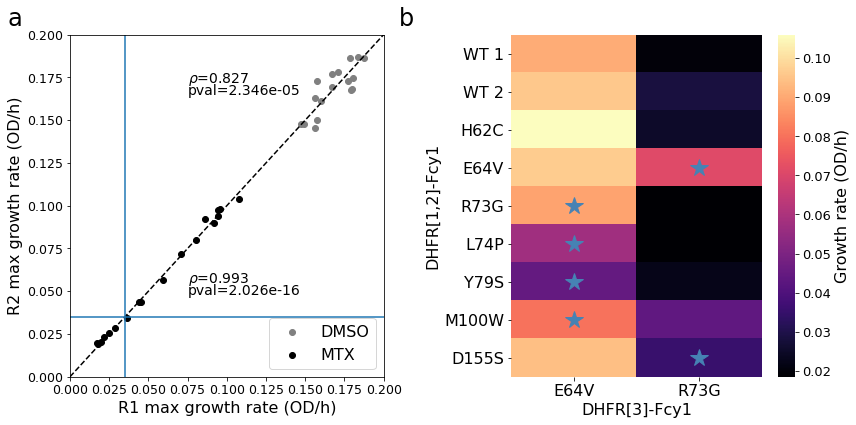

In [32]:
plt.figure(figsize=(12,6), facecolor='white')

ax1 = plt.subplot(121)
plt.scatter(strain_subset['DMSO_1'], strain_subset['DMSO_2'], color='grey')
print(stats.spearmanr(strain_subset['DMSO_1'], strain_subset['DMSO_2']))

vals = stats.spearmanr(strain_subset['DMSO_1'], strain_subset['DMSO_2'])
plt.text(0.075,0.172, r'$\rho$='+str(np.round(vals[0], 3)), fontsize=14)
plt.text(0.075,0.165, 'pval='+str(np.format_float_scientific(vals[1],3)), fontsize=14)



plt.scatter(strain_subset['MTX_1'], strain_subset['MTX_2'], color='k')
print(stats.spearmanr(strain_subset['MTX_1'], strain_subset['MTX_2']))


vals = stats.spearmanr(strain_subset['MTX_1'], strain_subset['MTX_2'])
plt.text(0.075,0.055, r'$\rho$='+str(np.round(vals[0], 3)), fontsize=14)
plt.text(0.075,0.048, 'pval='+str(np.format_float_scientific(vals[1],3)), fontsize=14)

plt.legend(['DMSO', 'MTX'], fontsize=16)
plt.xlim(0,0.20)
plt.ylim(0,0.20)

plt.xlabel('R1 max growth rate (OD/h)', fontsize=16)
plt.ylabel('R2 max growth rate (OD/h)', fontsize=16)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)


plt.plot([0,0.20], [0,0.20], 'k--')
plt.axvline(0.035)
plt.axhline(0.035)

#################################
plt.subplot(122)

pca_heatmap_array = strain_subset.pivot_table(index='mata', columns='matalpha', values='MTX_mean')
rows = ['WT_1', 'WT_2', 'H62C_1', 'E64V_1', 'R73G_2', 'L74P_1', 'Y79S_2', 'M100W_1', 'D155S_1']
g = sns.heatmap(pca_heatmap_array.loc[rows], cmap='magma', cbar_kws=dict(label='Growth rate (OD/h)'))

g.figure.axes[-1].yaxis.label.set_size(16)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)



cbar_kws=dict(label='Growth rate (OD/h)')

plt.xticks([0.5,1.5], ['E64V', 'R73G'], fontsize=16)
plt.xlabel('DHFR[3]-Fcy1', fontsize=16)

plt.yticks([0.5,1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], ['WT 1', 'WT 2', 'H62C', 'E64V', 'R73G', 'L74P', 'Y79S', 'M100W', 'D155S'], fontsize=16)
plt.ylabel('DHFR[1,2]-Fcy1', fontsize=16)


ax1.text(-0.04, 0.205, 'a', fontsize=24)
ax1.text(0.21, 0.205, 'b', fontsize=24)

plt.plot([0.5], [4.5], '*', color='steelblue', ms=18)
plt.plot([0.5], [5.5], '*', color='steelblue', ms=18)
plt.plot([0.5], [6.5], '*', color='steelblue', ms=18)
plt.plot([0.5], [7.5], '*', color='steelblue', ms=18)

plt.plot([1.5], [3.5], '*', color='steelblue', ms=18)
plt.plot([1.5], [8.5], '*', color='steelblue', ms=18)



plt.tight_layout()
plt.savefig('./figures/PCA_data.svg', format='svg', dpi=300)